# Exploring EAZY results

* Load and print results
* Label color image with id numbers and photo-z's
* Galaxy card compiling color image and plots

Gabe Brammer's grizli reduction of JWST ERO SMACS0723

products: https://s3.amazonaws.com/grizli-v2/SMACS0723/Test/image_index.html

interactive plots: https://smacs0723-photoz.herokuapp.com/

code:
https://github.com/gbrammer/grizli-notebooks/blob/main/JWST/ceers-nircam-imaging.ipynb

EAZY: https://eazy-py.readthedocs.io

plotting: https://eazy-py.readthedocs.io/en/latest/api/eazy.photoz.PhotoZ.html

## Imports

In [1]:
import eazy
import eazy.hdf5

In [2]:
from astropy.table import Table
import astropy.units as u

import numpy as np
from glob import glob

In [3]:
# to show segmentation map
import photutils

In [4]:
# for labeling color image
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs

from PIL import Image, ImageDraw, ImageFont

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Helper functions

In [6]:
def extract_id(cat, id, idlabel='id'): # choose_object select_object
    # Note input id must be same format as cat[idlabel] (int or string)
    # to create an array with mostly False entries and True for id
    # cat['id'] dtype='int64'
    # cat['id'] == 3: [False, False, True, False...]
    # cat['id'] == '3': False
    #
    # obj:          astropy.table.table.Table
    # obj[0]:       astropy.table.row.Row
    # obj['id']:    astropy.table.column.Column
    # obj[0]['id']: numpy.int64
    duck_duck_goose = cat[idlabel] == int(id)
    if len(duck_duck_goose):
        obj = cat[duck_duck_goose]
    return obj[0]

In [7]:
def between(lo, x, hi):
    return (x < lo) * (x < hi)

In [8]:
# Format exponential ticks to read as simple numbers unless too big / small
def fmtexp(x, pos):
    if between(1e-4, x, 1e4):
        s = '%g' % x
    else:
        p = int(np.log10(x))
        d = int(np.round(x / 10**p))
        #print d
        s = ''
        if d > 1:
            s += '%d$\\times$' % d
    
        s += '10${\\mathdefault{^{%d}}}$' % p
    return s

# Conversions for second axis
def AB2uJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.uJy)
    return f.value

def uJy2AB(F_uJy):
    f = F_uJy * u.uJy
    m = f.to(u.ABmag)
    return m.value

def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    return f.value

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    return m.value

# Load EAZY results

In [9]:
zoutfile = 'smacs0723.eazypy.zout.fits'
eazy_results = Table.read(zoutfile)

In the .h5 file, EAZY saved local paths to templates and FILTER.RES.latest.   
Link to them on your machine so we can find them now! For example:

ln /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/templates   
ln /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/filters/FILTER.RES.latest

In [10]:
h5file  = 'smacs0723.eazypy.h5'
eazy_run = eazy.hdf5.initialize_from_hdf5(h5file=h5file)

Read default param file: /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 7585
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f1000w_tot_1 f1000w_etot_1 (397): jwst_miri_f1000w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f1500w_tot_1 f1500w_etot_1 (400): jwst_miri_f1500w
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f1800w_tot_1 f1800w_etot_1 (401): jwst_miri_f1800w
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f356w_tot_1 f356w_etot_1 (376): jwst_nircam_f356w
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w_tot_1 f444w_etot_1 (377): jwst_nircam_f444w
f60

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/photoz.py:1325: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))


Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)
TemplateGrid: user-provided tempfilt_data
Process templates: 0.503 s


277it [00:00, 431.29it/s]


h5: read tweak_fsps_QSF_12_v3_001.dat
h5: read tweak_fsps_QSF_12_v3_002.dat
h5: read tweak_fsps_QSF_12_v3_003.dat
h5: read tweak_fsps_QSF_12_v3_004.dat
h5: read tweak_fsps_QSF_12_v3_005.dat
h5: read tweak_fsps_QSF_12_v3_006.dat
h5: read tweak_fsps_QSF_12_v3_007.dat
h5: read tweak_fsps_QSF_12_v3_008.dat
h5: read tweak_fsps_QSF_12_v3_009.dat
h5: read tweak_fsps_QSF_12_v3_010.dat
h5: read tweak_fsps_QSF_12_v3_011.dat
h5: read tweak_fsps_QSF_12_v3_012.dat
fit_best: 0.9 s (n_proc=1,  NOBJ=6492)


## Example outputs

In [11]:
eazy_run.cat[:2]

id,ra,dec,z_spec,f090w_tot_1,f090w_etot_1,f1000w_tot_1,f1000w_etot_1,f105w_tot_1,f105w_etot_1,f115wn_tot_1,f115wn_etot_1,f125w_tot_1,f125w_etot_1,f140w_tot_1,f140w_etot_1,f1500w_tot_1,f1500w_etot_1,f150w_tot_1,f150w_etot_1,f160w_tot_1,f160w_etot_1,f1800w_tot_1,f1800w_etot_1,f200w_tot_1,f200w_etot_1,f200wn_tot_1,f200wn_etot_1,f277w_tot_1,f277w_etot_1,f356w_tot_1,f356w_etot_1,f435w_tot_1,f435w_etot_1,f444w_tot_1,f444w_etot_1,f606w_tot_1,f606w_etot_1,f770w_tot_1,f770w_etot_1,f814w_tot_1,f814w_etot_1
int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,110.909890,-73.512360,-1.00000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000
2,110.857060,-73.512392,-1.00000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000


In [12]:
eazy_run.zbest

array([-1.        , -1.        , -1.        , ...,  5.4177885 ,
        0.35121015,  0.3150699 ], dtype=float32)

In [13]:
eazy_results[:2]

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,Lv_p,mass_p,LIR_p,sfr_p,Av_p,ssfr_p
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,solLum,solMass,solLum,solMass / yr,,1 / yr
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
1,110.90989049218415,-73.51235969091496,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29
2,110.85705952558388,-73.51239196787034,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29


In [14]:
len(eazy_run.cat), len(eazy_results)

(7585, 7585)

In [15]:
id = 6732  # very red galaxy HST dark just outside MIRI imaging
obj = extract_id(eazy_results, id)
obj

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,Lv_p,mass_p,LIR_p,sfr_p,Av_p,ssfr_p
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,solLum,solMass,solLum,solMass / yr,,1 / yr
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
6732,110.85823657259083,-73.4444107397023,-1.0,15,4.588787,17.043737,0.15774325,4318.8,44036.7,4.588787,17.043737,0.15774325,4.584251,0.15786262,4.584251,17.0400,3.5738,4.2488,4.6214,5.0482,5.5083,0.243,0.010,0.732,0.033,1.503,0.047,10.136,2.368,4.2e+04,8.17e+10,3.00e+11,0.151,5.38e+10,0.00e+00,1.75,-99.00,3.67,7.22e-01 .. 8.53e-01,2.28e+11 .. 3.33e+11,2.98e+10 .. 6.17e+10,0.108 .. 0.168,1.10 .. 1.92,3.82e-13 .. 5.94e-13


In [16]:
obj['sfr']  # solMass / yr

0.15079255317708373

In [17]:
obj['mass']  # solMass

299835110578.31

In [18]:
obj['sfr'] / obj['mass'] * 1e9  # sSFR: specific star formation rate (/ Gyr)

0.0005029182635957512

In [19]:
obj['ssfr_p'] * 1e9  # percentiles

array([0.00038164, 0.00043974, 0.00051656, 0.00055555, 0.00059363])

# Load color image and segmentation map

In [20]:
# Segmentation map
segm_file = 'smacs0723-ir_seg.fits'
segm = fits.open(segm_file)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

In [21]:
# Color image
color_image_file = '../color/smacs0723_color_bright.png'
im = Image.open(color_image_file)
color_image = np.asarray(im)
color_image = color_image[::-1]

In [34]:
#image_files = glob('../images/*.fits')
#infile = image_files[0]
hdu = fits.open(segm_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
#image_wcs

In [35]:
# Calculate x,y -- to be used for image stamps
catalog_coordinates = SkyCoord(ra=eazy_results['ra'], dec=eazy_results['dec'])  # *u.deg
eazy_results['x'], eazy_results['y'] = image_wcs.world_to_pixel(catalog_coordinates)
eazy_run.cat['x'], eazy_run.cat['y'] = image_wcs.world_to_pixel(catalog_coordinates)

## Show and look for interesting objects

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9.5, 5), sharex=True, sharey=True)

ax[0].imshow(color_image, origin='lower')
ax[0].set_title('Color')

cmap = segm.make_cmap(seed=12345)  # ERROR
ax[1].imshow(segm.data, origin='lower', cmap=cmap, interpolation='nearest')
ax[1].set_title('Segment')

# Label color image

In [ ]:
# Produce static color image with labels that you can share, view full screen, etc.
# Label the color image with id numbers or photo-z's
# like my old imlabel.py or bpzlabel.py

In [ ]:
text_color = 255,255,0  # text color yellow because white blends into cores
text_font = ImageFont.load_default()  # text font

In [ ]:
#eazy_run.cat.write('smacs0723_grizli_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [ ]:
im = Image.open(color_image_file)
draw = ImageDraw.Draw(im)
nx, ny = im.size

In [ ]:
for i in range(len(eazy_results)):
    x = eazy_results['x'][i]
    y = ny - eazy_results['y'][i]
    id = eazy_results['id'][i]
    draw.text((x, y), '%d' % id, fill=text_color, font=text_font)

In [ ]:
#im.show()
outfile = 'smacs0723_id.png'
im.save(outfile)

## Mark photometric redshifts on color image

In [ ]:
cmap = matplotlib.cm.get_cmap("rainbow")

In [ ]:
z = eazy_results['z_phot']

In [ ]:
im = Image.open(color_image_file)
draw = ImageDraw.Draw(im)
nx, ny = im.size

In [ ]:
zmax = 8  # limit shows up red

for i in range(len(eazy_results)):
    x = eazy_results['x'][i]
    y = ny - eazy_results['y'][i]
    id = eazy_results['id'][i]
    color = tuple((255 * np.array(cmap(z[i] / zmax))[:-1]).astype(int))
    if z[i] < 0:
        fmt = '%d'
        color = 100, 100, 100
    elif z[i] < zmax:
        fmt = '%.2f'
    else:
        fmt = '%.1f'
    draw.text((x, y), fmt % z[i], fill=color, font=text_font)
    
#im.show()
outfile = 'smacs0723_eazy.png'
im.save(outfile)

# Plot SED fits

<IPython.core.display.Javascript object>


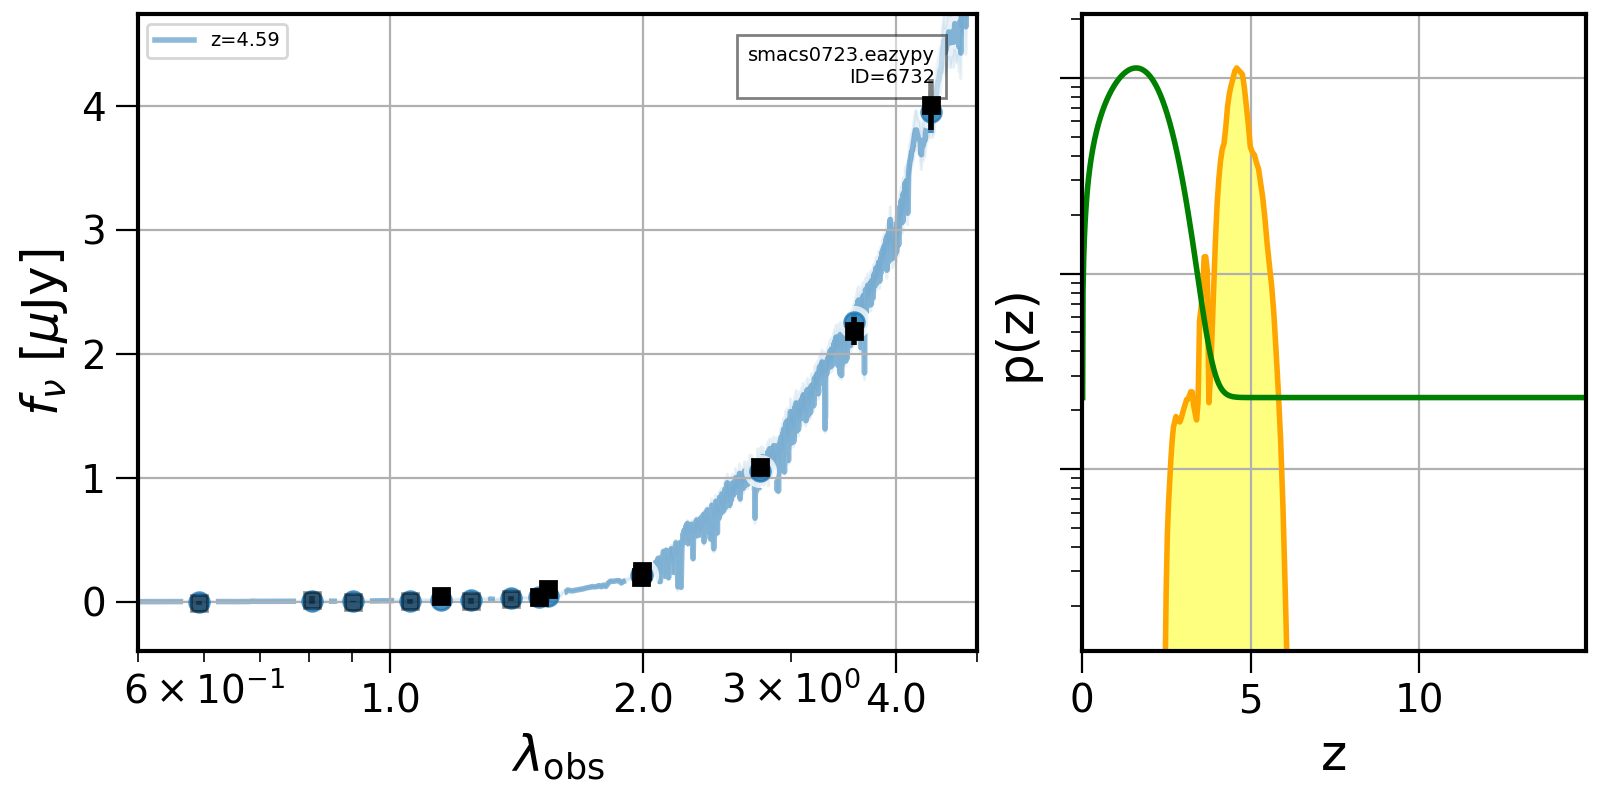

In [22]:
id = 6732
fig, data = eazy_run.show_fit(id, xlim=[0.5, 5], show_fnu=True, logpz=True, show_prior=True)

<IPython.core.display.Javascript object>


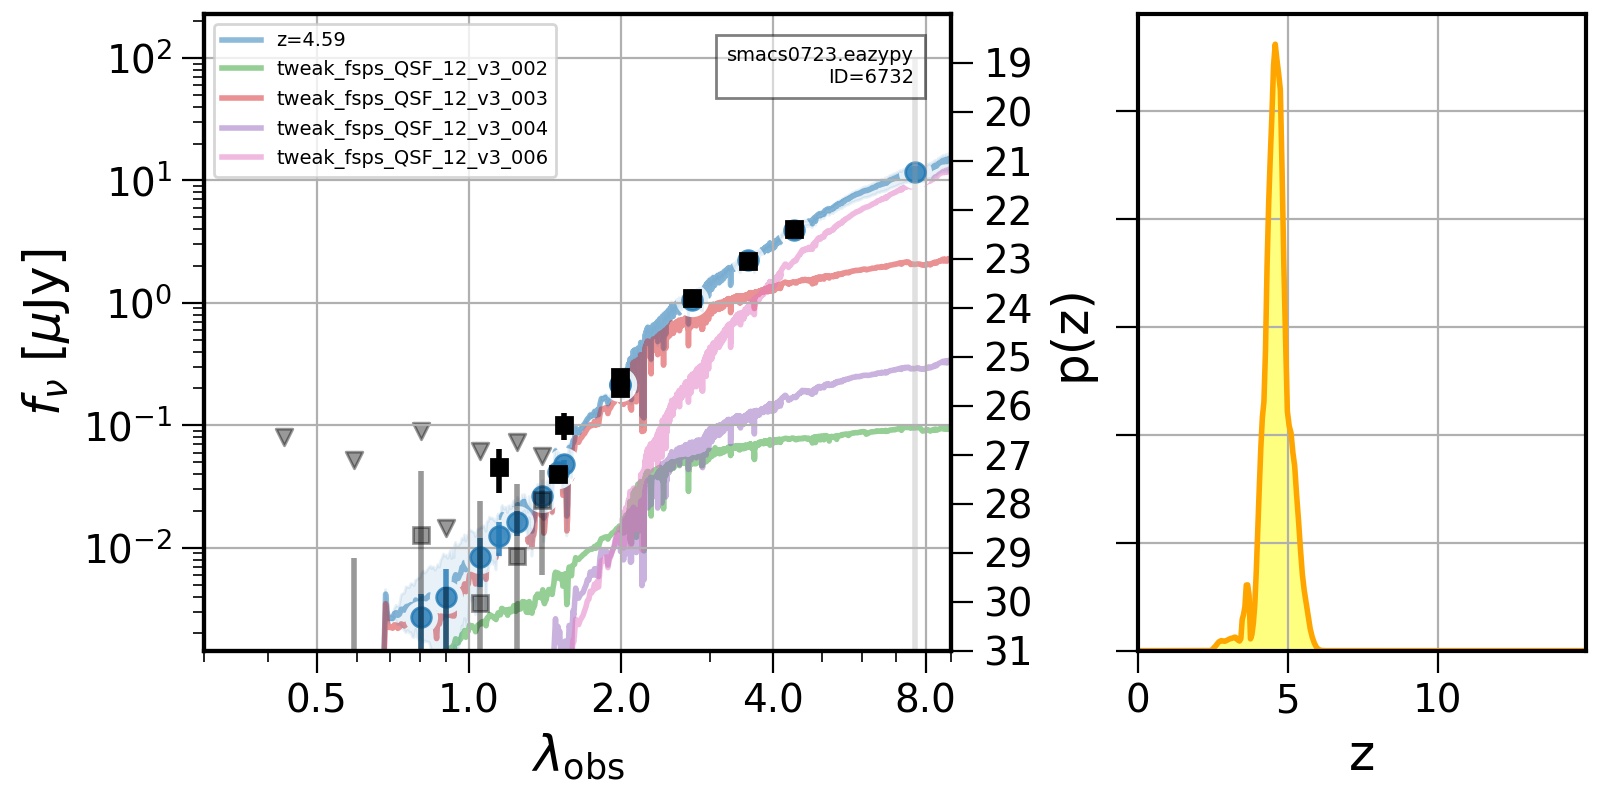

In [23]:
fig, data = eazy_run.show_fit(id, show_fnu=True, maglim=(31,18), show_components=True)

<IPython.core.display.Javascript object>


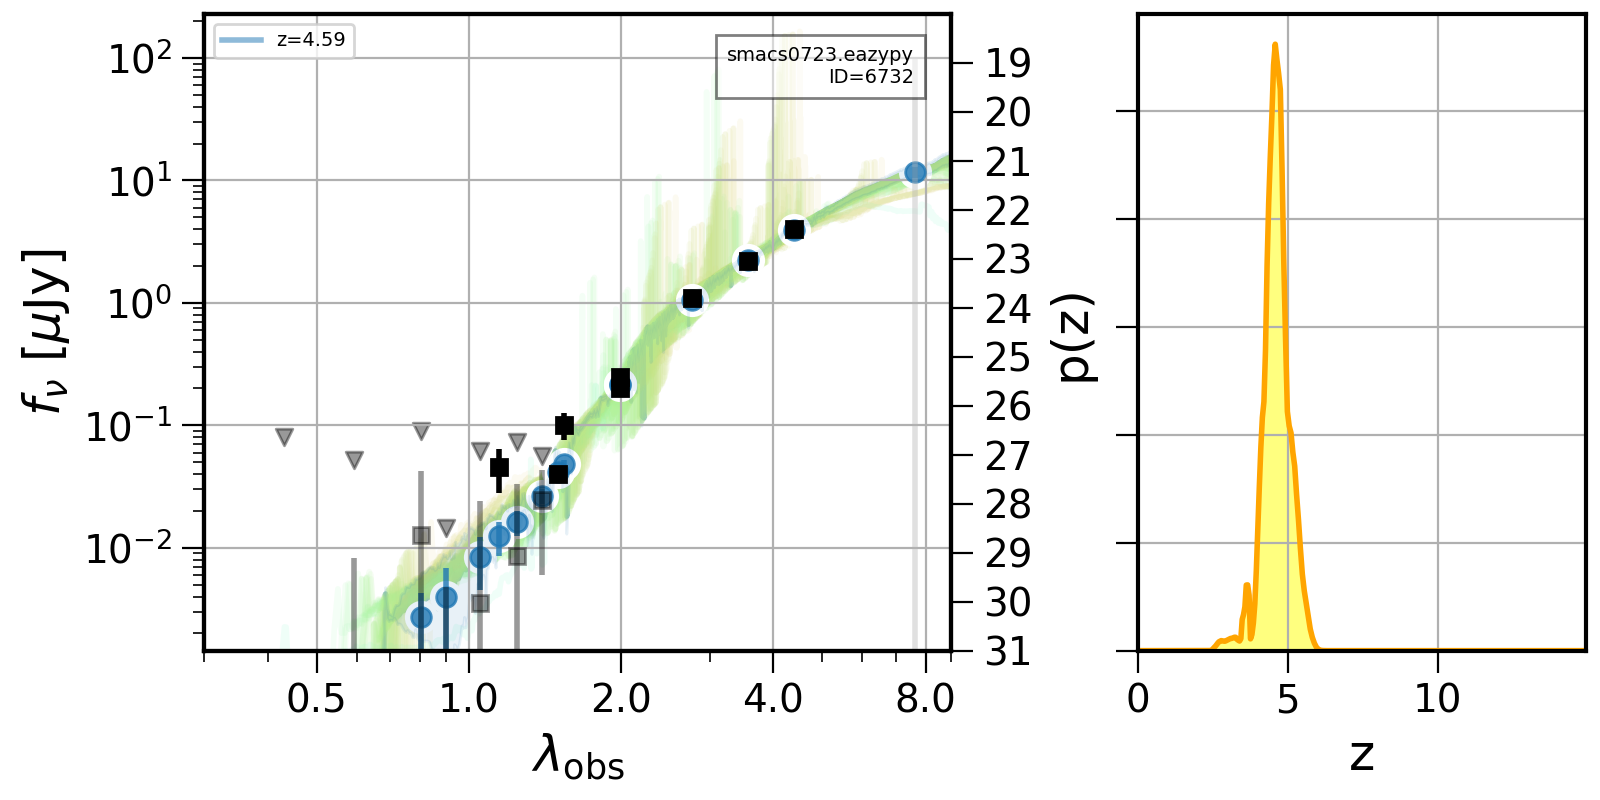

`star_chi2` attribute not found, run `fit_phoenix_stars`.


In [24]:
# Show range of SED fits... and stars if we'd fit them before
fig, data = eazy_run.show_fit(id, show_fnu=True, maglim=(31,18),
                             show_redshift_draws=True, show_stars=True)

<IPython.core.display.Javascript object>


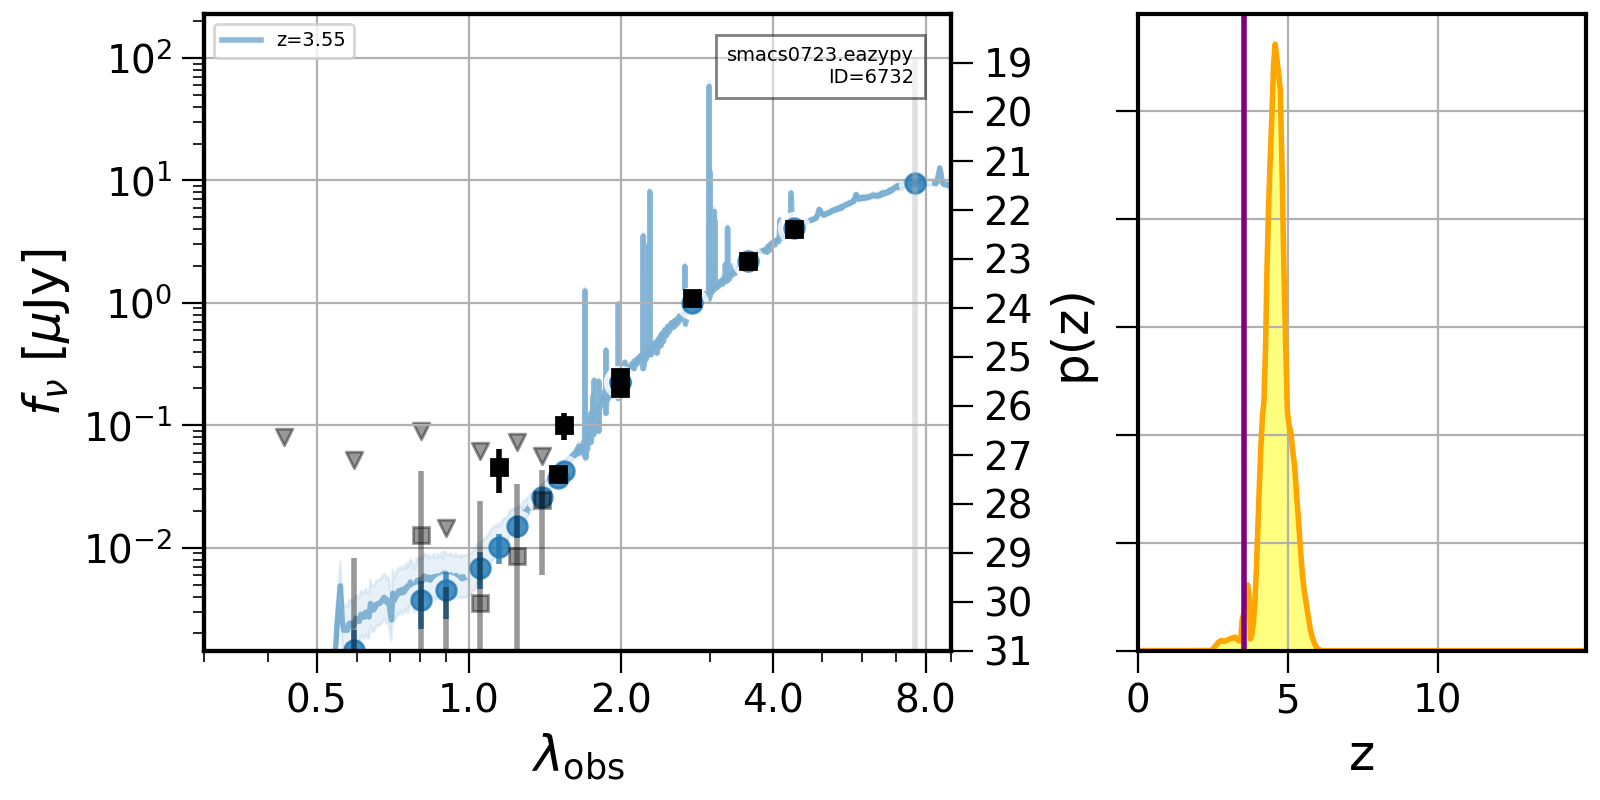

In [25]:
# Show best fit at a different redshift
fig, data = eazy_run.show_fit(id, show_fnu=True, maglim=(31,18), zshow=3.55)

In [26]:
data

OrderedDict([('ix', 6731),
             ('id', 6732),
             ('z', 3.55),
             ('z_spec', -1.0),
             ('pivot',
              array([  9022.92216966,  99471.09258361,  10543.5232349 ,  11494.9042696 ,
                      12470.52032283,  13924.16391632, 150481.55266467,  15007.45490818,
                      15396.61615459, 179696.73556279,  19886.47813979,  19923.33048731,
                      27577.95876438,  35682.2776384 ,   4318.82810211,  44036.71097715,
                       5920.81887956,  76364.11731878,   8056.87950929])),
             ('model',
              array([4.48276880e-03, 9.03813599e+00, 6.89677487e-03, 1.01397017e-02,
                     1.51089854e-02, 2.61745202e-02, 8.74523743e+00, 3.72239523e-02,
                     4.24389082e-02, 6.04048197e+00, 2.24263833e-01, 2.27262097e-01,
                     9.88742032e-01, 2.20698117e+00, 1.39520612e-04, 4.07495573e+00,
                     1.46504432e-03, 9.47098871e+00, 3.76853129e-03])),


In [27]:
data['flux_unit']

Unit("uJy")

In [28]:
data['wave_unit']

Unit("Angstrom")

# Show a galaxy (or any object) detected in the image

In [29]:
# Show color image and segment
def show_galaxy(id, figsize=(10, 5)):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = extract_id(eazy_results, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(color_image)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    plt.xlabel('')
    plt.ylabel('')
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(segm.data, cmap=cmap)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    plt.xlabel('')
    plt.ylabel('')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    fig.tight_layout()
    
    return fig

<IPython.core.display.Javascript object>


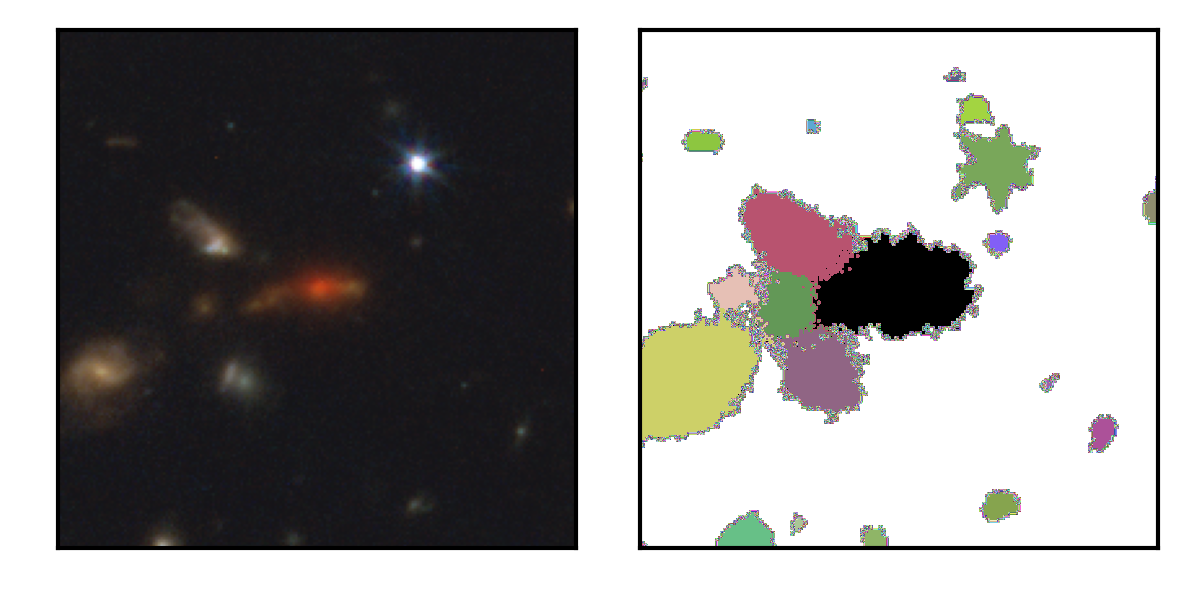

In [36]:
fig = show_galaxy(id, figsize=(6,3))

In [ ]:
fig.savefig('galaxy_%d.png' % id) #, dpi=200)

# Show galaxy and its properties

In [50]:
def plot_SED(id, fig, ax, plot_flux_units=u.uJy, plot_wavelength_units=u.um, rest_lam_interval=1000,
             obs_color='c', SED_color='brown', model_color='brown', model_lw = 0.7, model_alpha = 0.7):

    data = eazy_obj_data = eazy_run.show_fit(id, show_fnu=True, get_spec=True)
    z_phot = eazy_obj_data['z']  # photo-z
    #id = eazy_obj_data['id']
    #ix = eazy_obj_data['ix']
    #z = eazy_run.zgrid
    #pz = np.exp(eazy_run.lnp[ix]).flatten()

    #obj = extract_id(eazy_results, id)

    #eazy_flux_units = u.erg / u.s / u.cm**2 / u.AA

    data['flux_unit']
    data['wave_unit']
    
    wavelengths  = (data['pivot'] * data['wave_unit']).to(plot_wavelength_units)
    #fluxes       = (data['fobs']  * eazy_flux_units).to(plot_flux_units, u.spectral_density(wavelengths))
    fluxes       = (data['fobs']  * data['flux_unit']).to(plot_flux_units)
    flux_errs    = (data['efobs'] * data['flux_unit']).to(plot_flux_units)
    model_fluxes = (data['model'] * data['flux_unit']).to(plot_flux_units)
    #model_fluxes = data['model'] * u.uJy

    # Missing data
    missing  = (data['fobs']  < eazy_run.param['NOT_OBS_THRESHOLD']) 
    missing |= (data['efobs'] < 0)

    snr_thresh = 1
    SNR = data['fobs'] / data['efobs']
    detected     = (~missing) & (SNR >  snr_thresh)
    not_detected = (~missing) & (SNR <= snr_thresh)

    # Plot y scale
    goodflux = fluxes > flux_errs

    flux_min = np.min(fluxes[detected].value)
    flux_max = np.max(fluxes[goodflux].value)

    model_flux_max = np.max(model_fluxes.value)
    model_flux_min = np.min(model_fluxes.value)

    upper_limits = flux_errs[not_detected].value
    upper_limit_min = np.min(upper_limits)

    flux_max = np.max([flux_max, model_flux_max])
    #if plot_full_spec:
    #    flux_max = np.max([flux_max, spec_max])

    flux_min = np.min([flux_min, upper_limit_min])

    if 0: # plot linear not implemented here
        flux_margin = 0.1 * (flux_max - flux_min)
        yhi = flux_max + flux_margin * 2
        ylo = flux_min - flux_margin
    else:
        yhi = flux_max * 1
        ylo = flux_min / 2


    #fig, ax = plt.subplots(figsize=(8, 5))

    # Observed flux error bars
    plt.errorbar(wavelengths[detected], fluxes[detected], flux_errs[detected],
                 ms=8, marker='o', mfc=obs_color, c='k', lw=3, alpha=0.5, ls='none')

    # Observed fluxes
    #plt.plot(wavelengths[detected], fluxes[detected],       'o', color=obs_color,   ms=8,  
    #         label='Input fluxes', zorder=10)#, scaley=False)

    # Model fluxes
    plt.plot(wavelengths[detected], model_fluxes[detected], 's', color=model_color, ms=10, mfc='None', 
             label='Model fluxes', zorder=10)#, scaley=False)

    #plt.semilogx()
    plt.semilogy()

    #plt.margins(1)
        
    ax.autoscale(False)
    
    # Non detections
    plt.plot(wavelengths[not_detected], flux_errs[not_detected],
             ms=8, marker='v', mfc=obs_color, c='k', lw=3, alpha=0.5, ls='none')

    # SED
    SED_wavelength = (data['templz'] * u.AA).to(u.um)
    SED_flux = data['templf'] * u.uJy
    plt.plot(SED_wavelength, SED_flux, '-', color=model_color, lw=model_lw, alpha=model_alpha, zorder=-10)

    #imin = SED_wavelength.value.searchsorted(xmin)
    #imax = SED_wavelength.value.searchsorted(xmax)
    #plt.plot(SED_wavelength[imin:imax], SED_flux[imin:imax], '-', color=model_color, lw=model_lw, alpha=model_alpha,
    #plt.plot(SED_wavelength, SED_flux, '-', scalex=False, scaley=False)

    #plt.xlim(xmin, xmax)
    #plt.ylim(ylo, yhi)

    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux ($\mu$Jy)')

    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmtexp))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

    secax = ax.secondary_yaxis('right', functions=(uJy2AB, AB2uJy))
    #secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
    secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    secax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))
    secax.set_ylabel('Magnitude (AB)')

    topax = add_rest_wavelength_axis(ax, z_phot, rest_lam_interval=rest_lam_interval)
    
    
def add_rest_wavelength_axis(ax, z, rest_units=1000*u.AA, rest_lam_interval=1000, obs_lam_interval=1):
    factor = u.um.to(rest_units)
    def bottom2top(x): return x / (1+z) * factor
    def top2bottom(x): return x * (1+z) / factor
    ax.xaxis.set_major_locator(ticker.MultipleLocator(obs_lam_interval))  # Original bottom axis (microns)
    topax = ax.secondary_xaxis('top', functions=(bottom2top, top2bottom))
    tick_locator = (rest_lam_interval*u.AA / rest_units).value
    topax.xaxis.set_major_locator(ticker.MultipleLocator(tick_locator))  # New top axis
    xticks = topax.get_xticks()
    xmin1, xmax1 = ax.get_xlim()
    xmax2 = bottom2top(xmax1)
    if xmax2 > 25:
        tick_locator *= (xmax2 // 25 + 1)
        topax.xaxis.set_major_locator(ticker.MultipleLocator(tick_locator))  # New top axis
    #rest_label = 'Rest Wavelength ($1000 \AA$)'
    rest_label = 'Rest Wavelength ($%d \\rm{\AA}$)' % rest_units.value
    if rest_units.value == 1:
        rest_label = 'Rest Wavelength ($\\rm{\AA}$)' % rest_units.value
    topax.set_xlabel(rest_label, fontsize=14)
    return topax

<IPython.core.display.Javascript object>


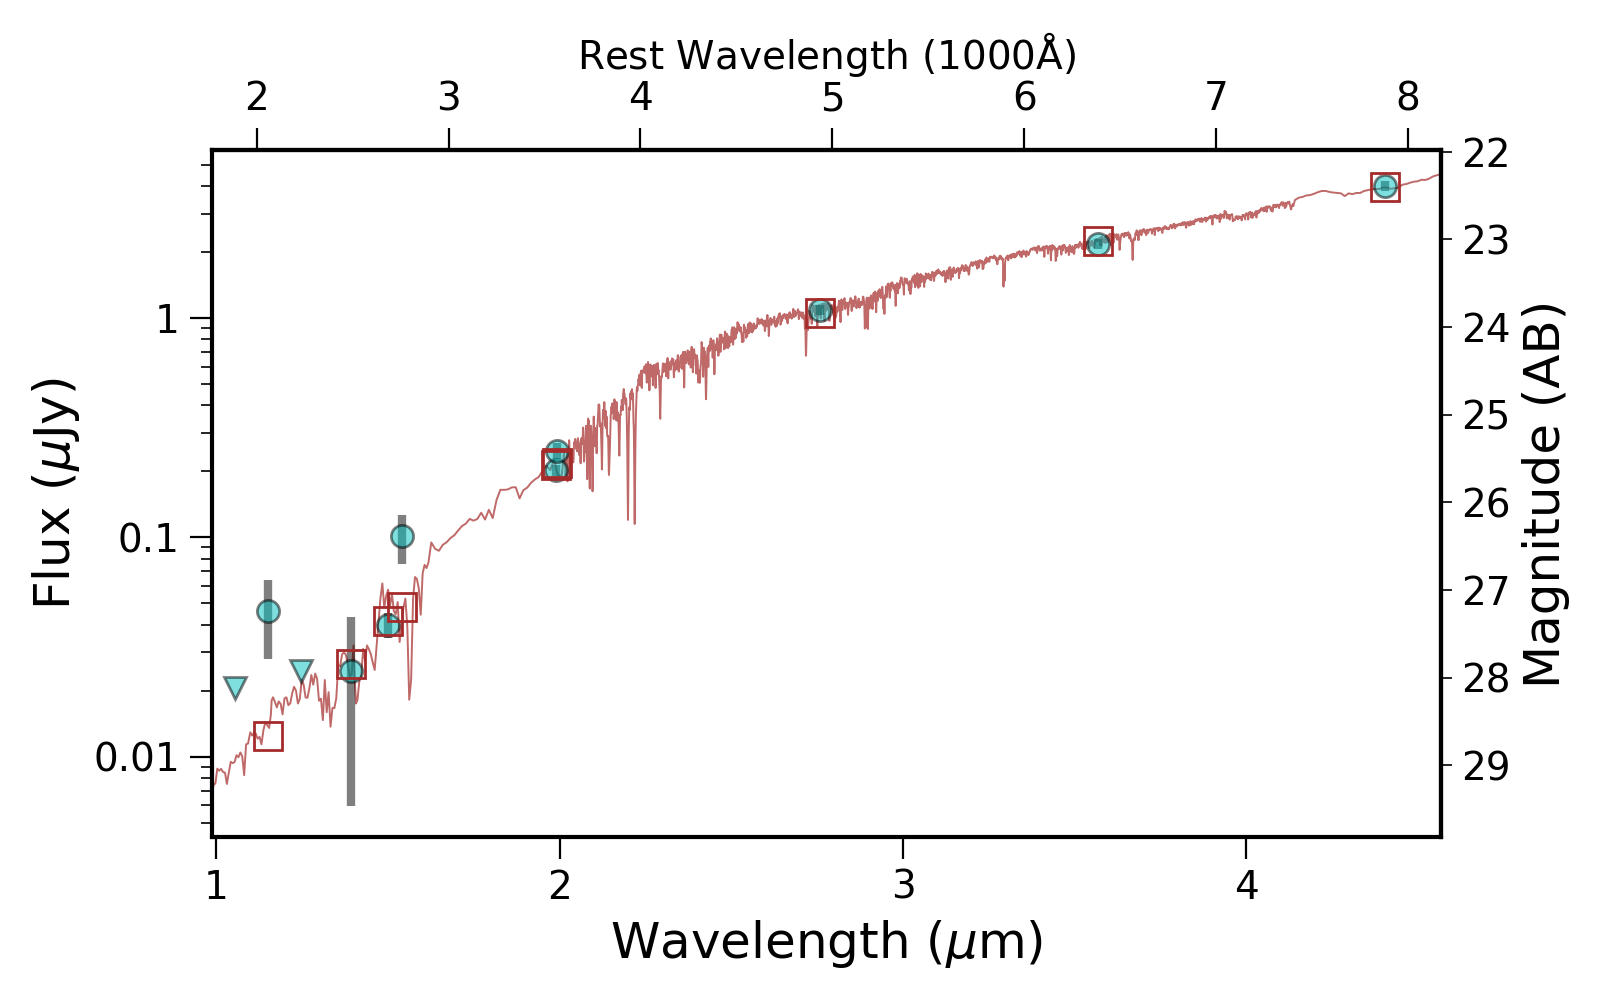

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_SED(id, fig, ax)

In [ ]:
id = 6732  # very red galaxy HST dark just outside MIRI imaging
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_SED(id, fig, ax)

In [ ]:
id
z = extract_id(eazy_results, id)['z_phot']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
add_rest_wavelength_axis(ax, z, rest_lam_interval=5000)
plot_SED(id, fig, ax)

In [48]:
def show_galaxy_properties(id, hist_color='C0', figsize=(12, 6), save=False):
    data = eazy_obj_data = eazy_run.show_fit(id, show_fnu=True,get_spec=True)
    #id = eazy_obj_data['id']
    ix = eazy_obj_data['ix']
    z = eazy_run.zgrid
    pz = np.exp(eazy_run.lnp[ix]).flatten()

    obj = extract_id(eazy_results, id)

    # Load data
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    # Create figure and gridspec
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 6, wspace=0)  # nrows, ncolumns

    # Color image
    #ax1 = fig.add_subplot(3,6,1)  # nrows, ncolumns, index
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(color_image)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    # Segmentation map
    #ax2 = fig.add_subplot(3,6,2)  # nrows, ncolumns, index
    ax2 = fig.add_subplot(gs[0,1])
    plt.imshow(segm.data, cmap=cmap)
    plt.xlim(xlo, xhi)
    plt.ylim(ylo, yhi)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # Redshift
    gs3 = fig.add_gridspec(100, 3, wspace=0.2)  # nrows, ncolumns
    ax3 = fig.add_subplot(gs3[45:50,0])
    #plt.hist(fit.posterior.samples['redshift'], ec=colors[0], lw=3)
    #plt.plot(z, pz, color=colors[0], lw=3)
    plt.fill_between(z, pz, pz*0, color=hist_color)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3.xaxis.tick_top()
    ax3.axes.yaxis.set_visible(False)
    ax3.set_title('Redshift', fontsize=16)

    # specific SFR (sSFR)
    ax3b = fig.add_subplot(gs3[70:75,0])
    ssfr_percentiles = extract_id(eazy_results, id)['ssfr_p']
    log_ssfr_Gyr_p = np.log10(ssfr_percentiles) + 9
    #plt.hist(log_sSFR, ec=colors[0], lw=3)
    #for log_ssfr_Gyr in log_ssfr_Gyr_p:
    #    plt.axvline(log_ssfr_Gyr, color=colors[0], lw=1)
    plt.fill_betweenx([0,1], log_ssfr_Gyr_p[0], log_ssfr_Gyr_p[-1], color=hist_color)
    plt.xlim(-4, +1)
    plt.ylim(0,1)
    ax3b.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3b.xaxis.tick_top()
    ax3b.axes.yaxis.set_visible(False)
    #ax3b.set_title('log sSFR ( / Myr)', fontsize=16)
    ax3b.set_title('log sSFR (Gyr$^{-1}$)', fontsize=16)

    # Dust
    ax3c = fig.add_subplot(gs3[95:100, 0])
    dust_percentiles = extract_id(eazy_results, id)['Av_p']
    plt.fill_betweenx([0,1], dust_percentiles[0], dust_percentiles[-1], color=hist_color)
    #for dust in dust_percentiles:
    #    plt.axvline(dust, color='c', lw=1)
    #plt.xlim(dust["Av"][0], dust["Av"][1])
    plt.xlim(0, 3)
    plt.ylim(0, 1)
    ax3c.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3c.xaxis.tick_top()
    ax3c.axes.yaxis.set_visible(False)
    ax3c.set_title('dust $A_V$ (mag)', fontsize=16)

    # SED
    gs4 = fig.add_gridspec(1, 3)  # nrows, ncolumns
    ax4 = fig.add_subplot(gs4[0,1:])
    #plt1, fig1, ax1, secax = 
    plot_SED(id, fig, ax4)

    if save:
        fig.savefig('EAZY_%d.png' % id)
    
    return fig

<IPython.core.display.Javascript object>


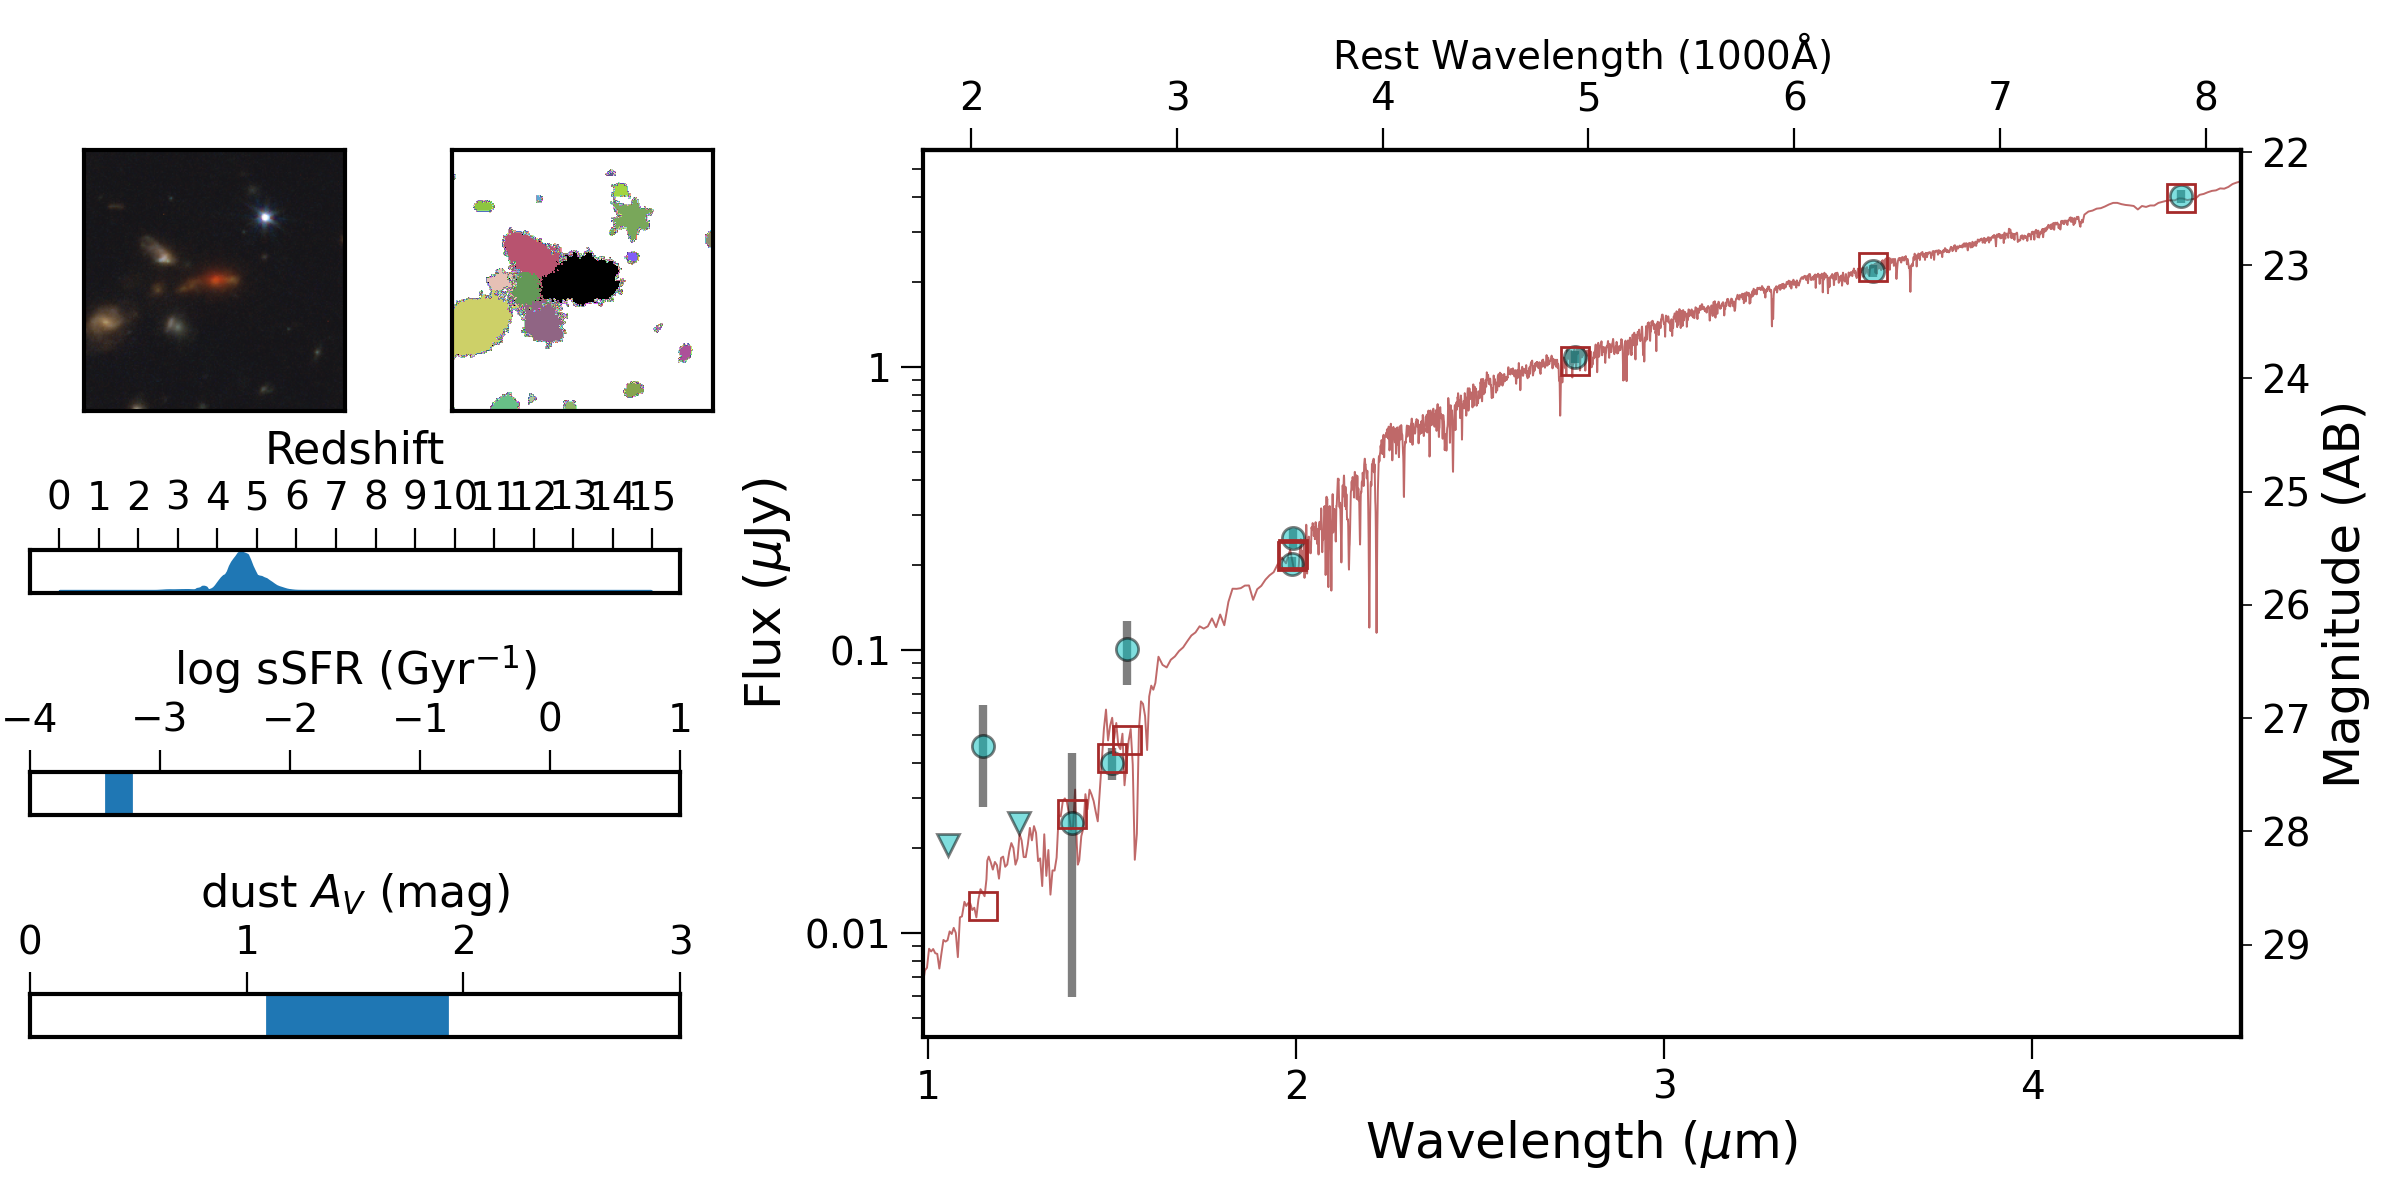

In [52]:
id = 6732  # very red galaxy HST dark just outside MIRI imaging
fig = show_galaxy_properties(id, figsize=(12, 6))

<IPython.core.display.Javascript object>


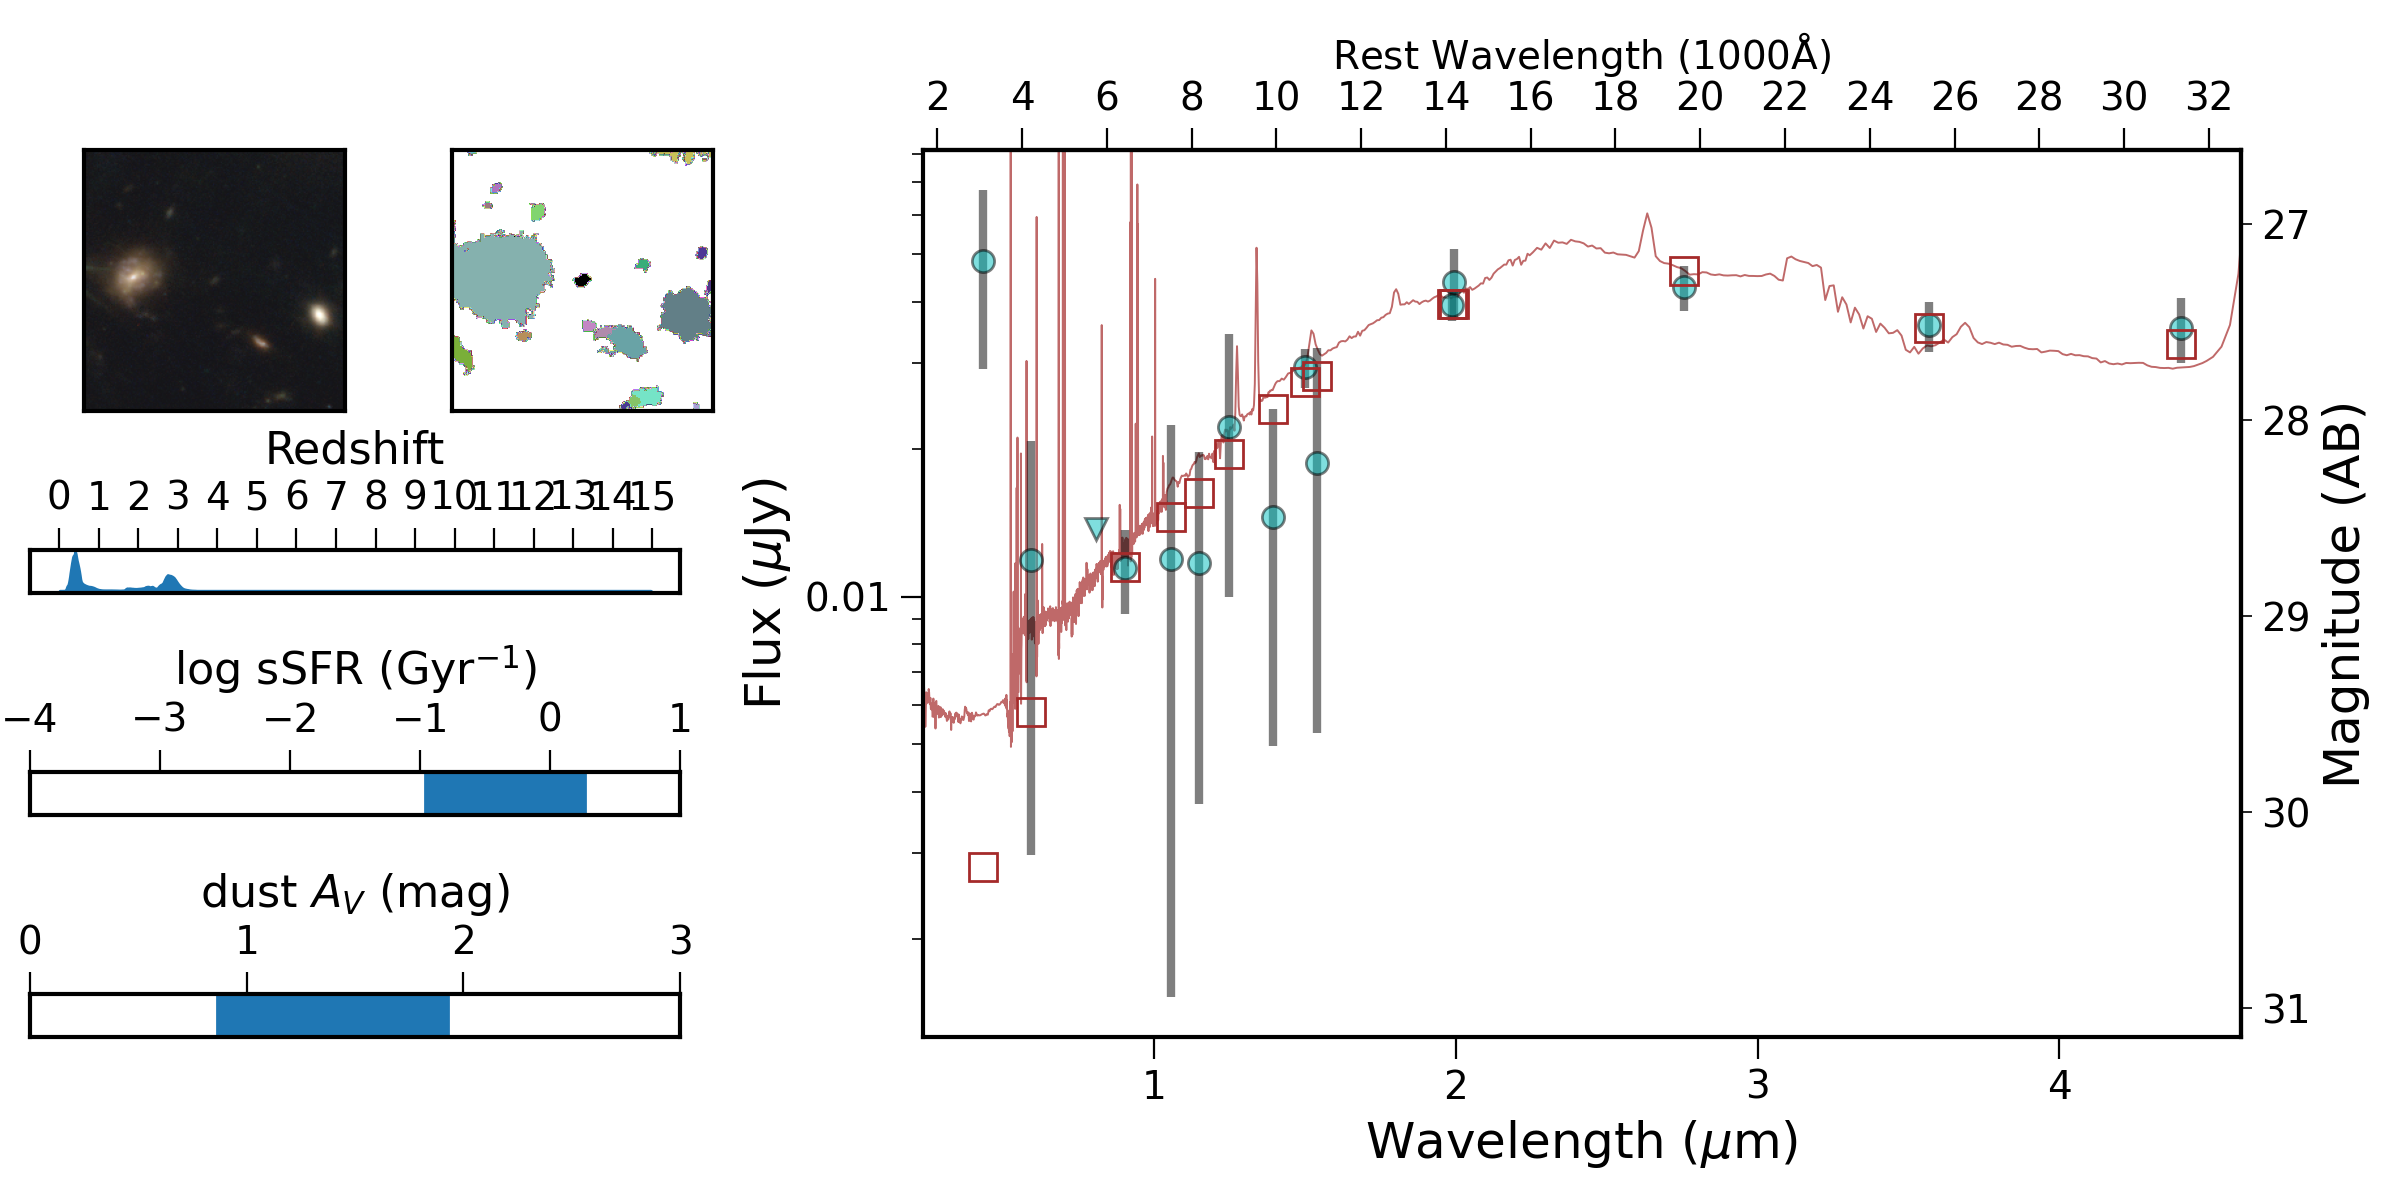

In [55]:
id = 4649  # ALMA detection ID1 (Cheng et al.)
fig = show_galaxy_properties(id, figsize=(12, 6))

<IPython.core.display.Javascript object>


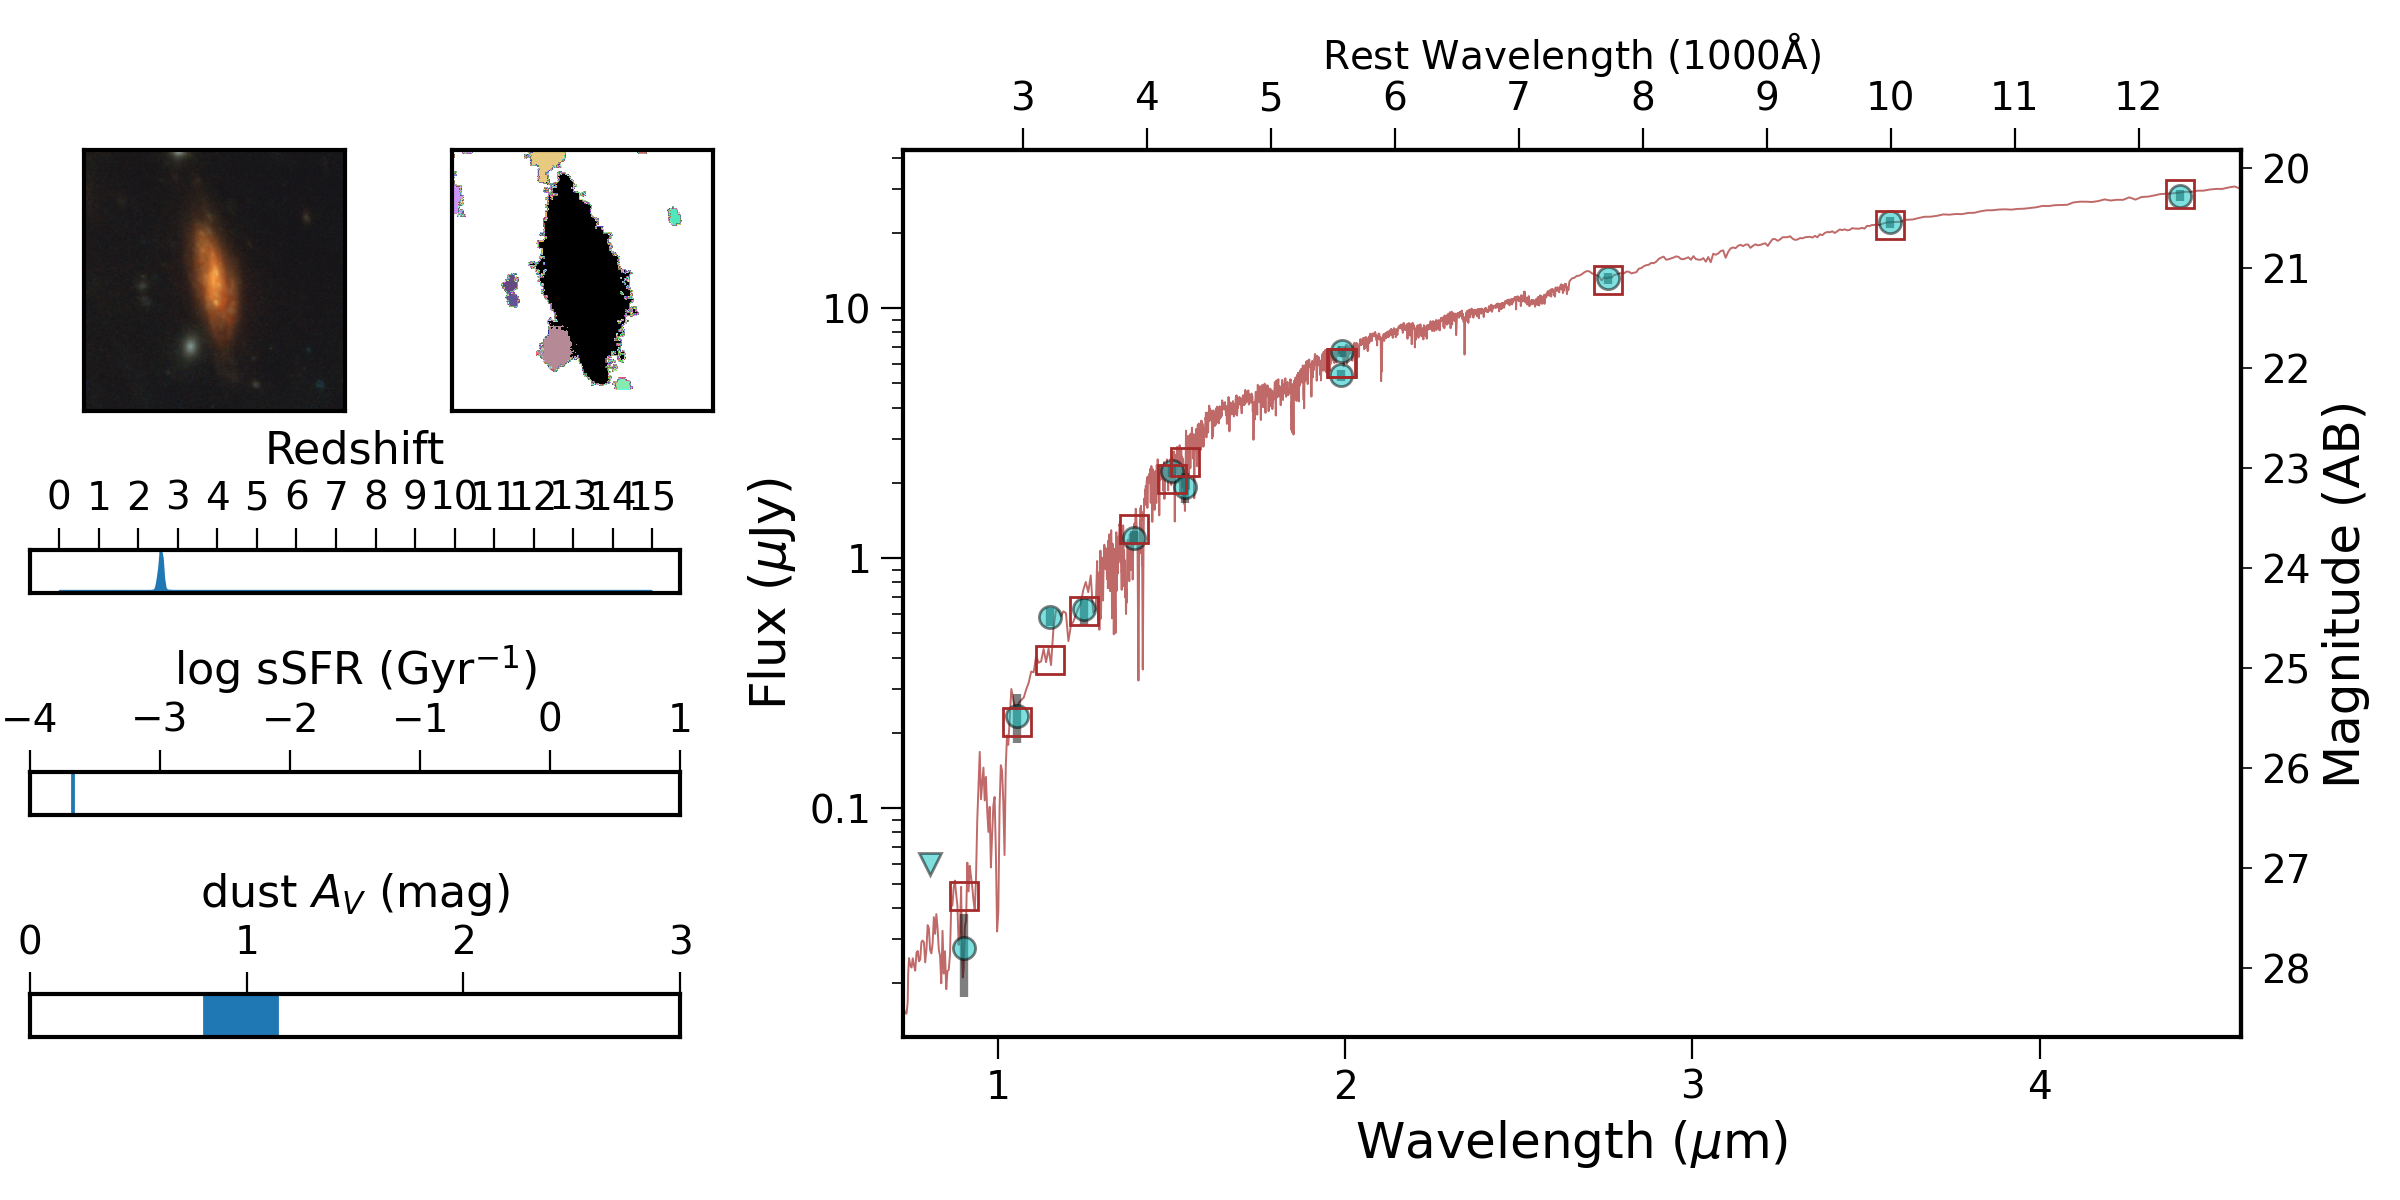

In [53]:
id = 6200  # ALMA detection ID2 (Cheng et al.)
fig = show_galaxy_properties(id, figsize=(12, 6))

<IPython.core.display.Javascript object>


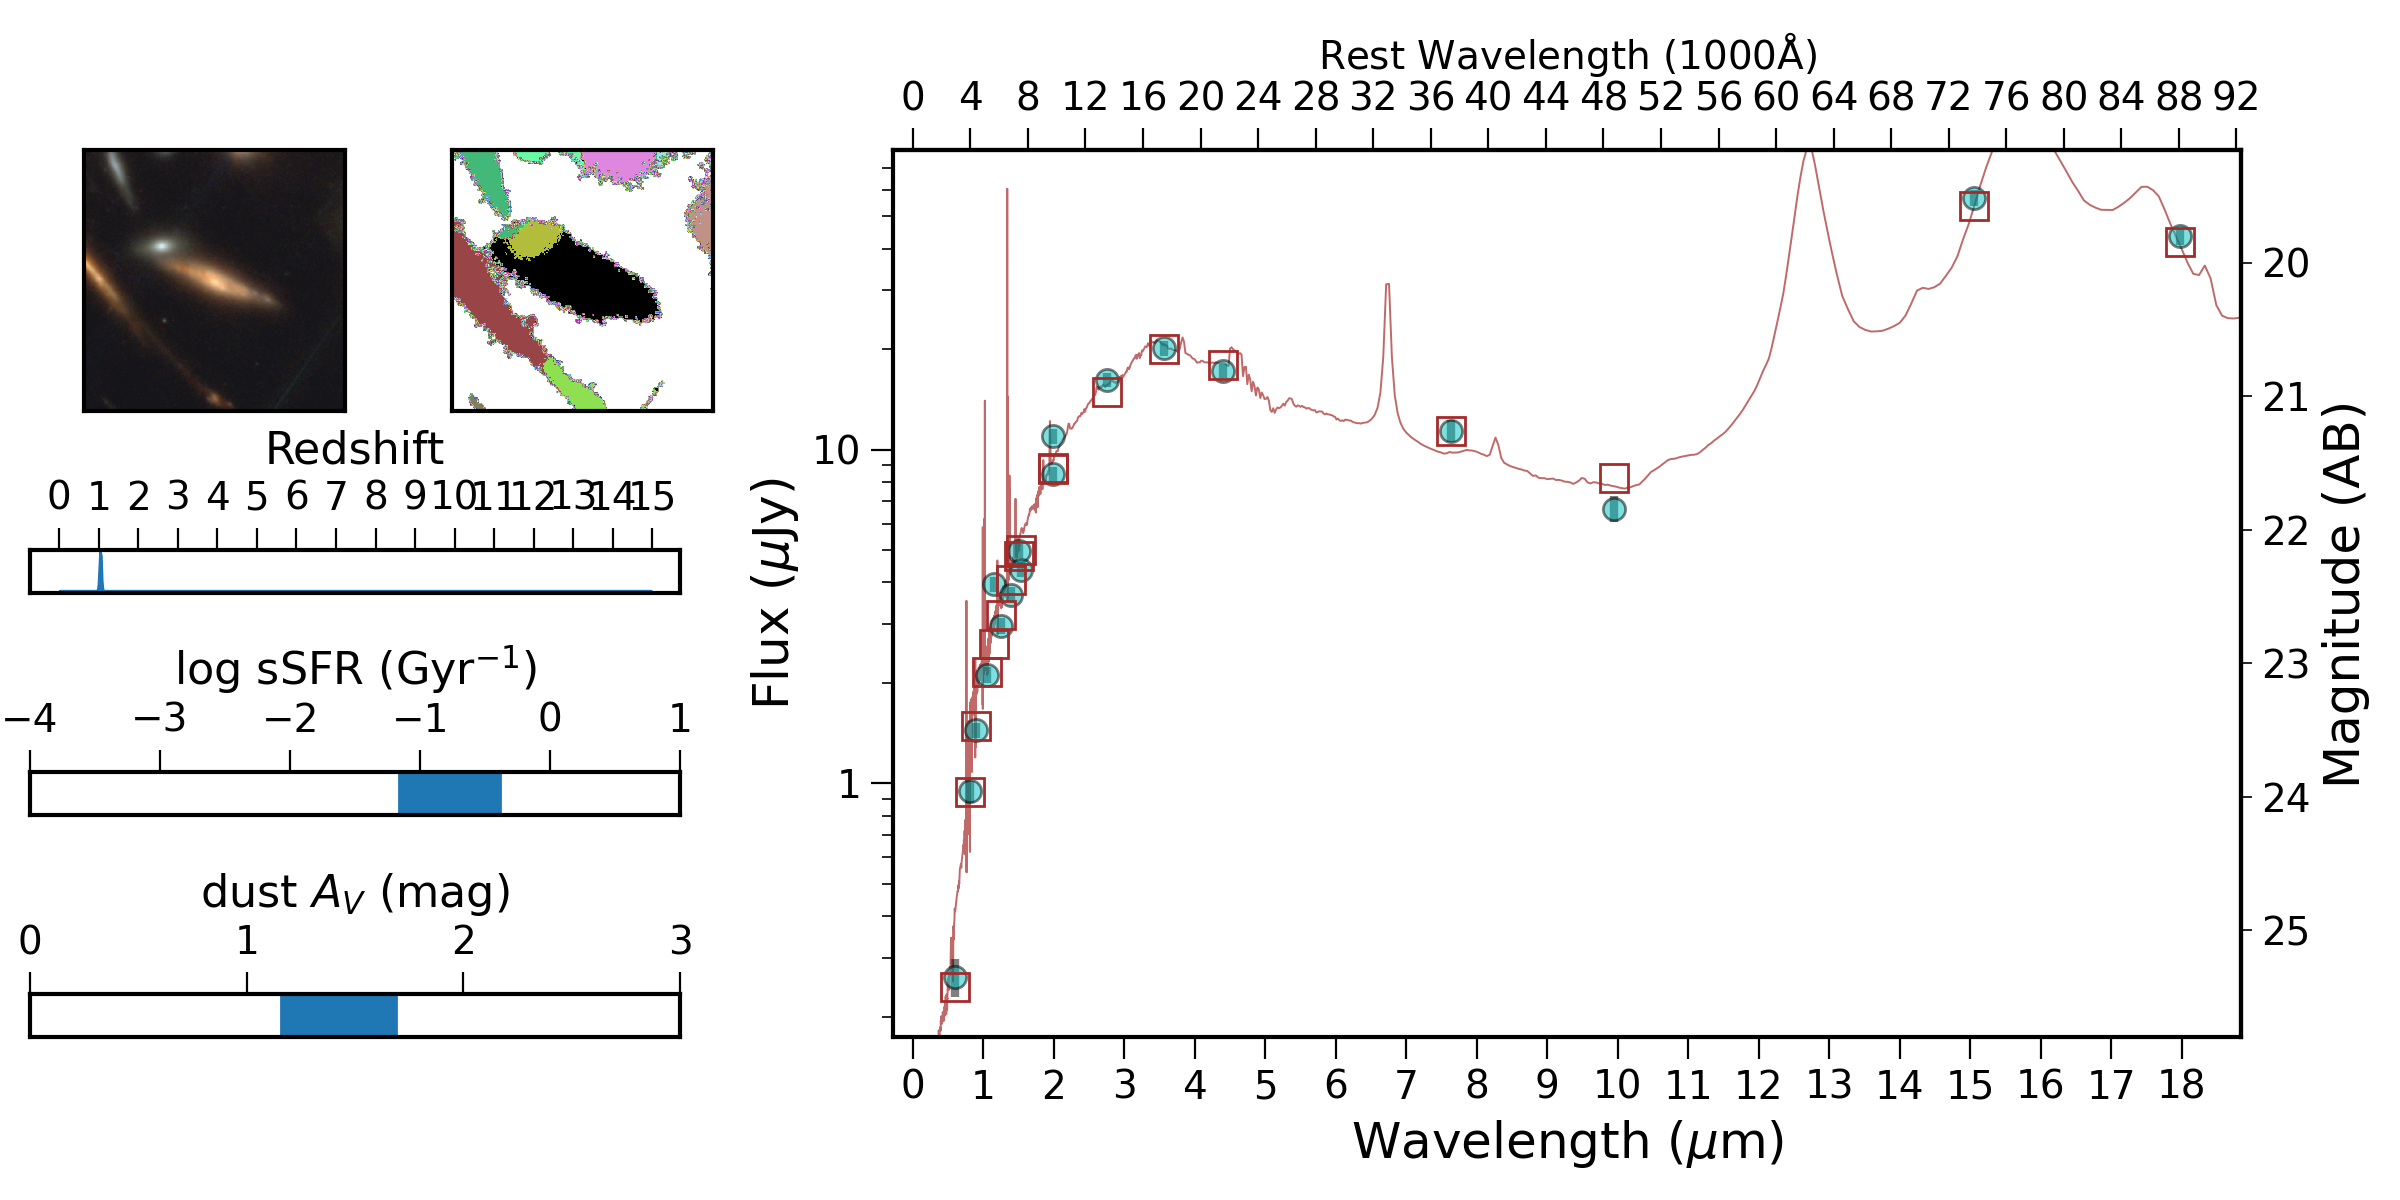

In [54]:
id = 5288  # ALMA detection ID3 (Cheng et al.)
fig = show_galaxy_properties(id, figsize=(12, 6))

In [ ]:
fig.savefig('EAZY_%d.png' % id)